In [1]:
from google.colab import drive
drive.mount('/content/sample')

Mounted at /content/sample


In [2]:
import os
os.listdir('/content/sample/MyDrive/ResNet')

['COVID-19_Radiography_Dataset.zip', 'xray_disease_app', 'ResNet_X-Ray']

In [3]:
import zipfile

with zipfile.ZipFile('/content/sample/MyDrive/ResNet/COVID-19_Radiography_Dataset.zip', 'r') as zip_ref:
    dirs = {name for name in zip_ref.namelist() if name.endswith('/images/')}
    print("\n".join(sorted(dirs)))

COVID-19_Radiography_Dataset/COVID/images/
COVID-19_Radiography_Dataset/Lung_Opacity/images/
COVID-19_Radiography_Dataset/Normal/images/
COVID-19_Radiography_Dataset/Viral Pneumonia/images/


In [4]:
if os.path.exists('/content/dataset/'):
  pass
else:
  os.makedirs('/content/dataset/')

In [5]:
# Define paths
zip_path = '/content/sample/MyDrive/ResNet/COVID-19_Radiography_Dataset.zip'
output_dir = '/content/dataset/'  # Target directory for extracted images

# Subdirectories to extract (map ZIP paths to target folders)
subdirs_to_extract = {
    'COVID-19_Radiography_Dataset/COVID/images/': 'covid',
    'COVID-19_Radiography_Dataset/Lung_Opacity/images/': 'lung_opacity',
    'COVID-19_Radiography_Dataset/Normal/images/': 'normal',
    'COVID-19_Radiography_Dataset/Viral Pneumonia/images/': 'viral_pneumonia'
}

# Create target directories
for target_folder in subdirs_to_extract.values():
    os.makedirs(os.path.join(output_dir, target_folder, 'images'), exist_ok=True)

# Extract only the selected `/images/` subdirectories
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for zip_subdir, target_folder in subdirs_to_extract.items():
        # Iterate over files in the ZIP subdirectory
        for file in zip_ref.namelist():
            if file.startswith(zip_subdir) and not file.endswith('/'):
                output_path = os.path.join(
                    output_dir,
                    target_folder,
                    'images',
                    os.path.relpath(file, zip_subdir)
                )

                # Ensure parent directory exists
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                # Extract file
                with open(output_path, 'wb') as f:
                    f.write(zip_ref.read(file))

print("Extraction complete! Dataset structure ready for ImageFolder.")

Extraction complete! Dataset structure ready for ImageFolder.


In [6]:
os.chdir('/content/dataset/')

In [7]:
os.listdir('/content/dataset')

['viral_pneumonia', 'covid', 'normal', 'lung_opacity']

In [8]:
if os.path.exists('/content/dataset/models'):
  os.rmdir('/content/dataset/models')
else:
  pass

In [9]:
os.listdir('/content/dataset')

['viral_pneumonia', 'covid', 'normal', 'lung_opacity']

In [10]:

for i in range(4):
  list_ = os.listdir('/content/dataset')
  print('Number of Images in {} are : {}'.format(list_[i] , len(os.listdir('/content/dataset/' + list_[i] + '/images') )))

Number of Images in viral_pneumonia are : 1345
Number of Images in covid are : 3616
Number of Images in normal are : 10192
Number of Images in lung_opacity are : 6012


In [11]:
# till now i have successfully created organized directory struture
# let create dataset followed by data loader

In [12]:
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset, random_split
from PIL import Image
import torchvision.transforms as tt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [13]:
class EfficientImageDataset(Dataset):
  def __init__(self, root_path, classes=None, valid_size=0.2, train_transform=None, valid_transform=None, seed=42):

    """
        Args:
            root_path: Path to root directory (contains class folders)
            classes: List of class names to include (None for all)
            valid_size: Fraction of data for validation (0.0 to 1.0)
            train_transform: Transforms for training data
            valid_transform: Transforms for validation data
            seed: Random seed for reproducible splits
    """
    self.root = root_path
    self.train_transform = train_transform
    self.valid_transform = valid_transform
    self.valid_size = valid_size
    self.seed = seed

    # Find all valid classes
    self.classes = sorted([d for d in os.listdir(root_path)
                             if os.path.isdir(os.path.join(root_path, d))])

    # Filter classes if specified
    if classes is not None:
      self.classes = [c for c in self.classes if c in set(classes)]

    self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    # Build index (lazy loading - only stores paths, not images)
    self.samples = []
    for class_name in self.classes:
      class_dir = os.path.join(root_path, class_name, 'images')
      if not os.path.exists(class_dir):
        continue

            # Get all image files
      for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png')):
          self.samples.append((
              os.path.join(class_dir, fname),
              self.class_to_idx[class_name]
          ))

  def get_splits(self):
    """Return train and validation datasets"""
    # Split indices
    num_valid = int(len(self.samples) * self.valid_size)
    num_train = len(self.samples) - num_valid

    # Split dataset (stratified by class if needed)
    train_indices, valid_indices = random_split(
        range(len(self.samples)),
        [num_train, num_valid],
        generator=torch.Generator().manual_seed(self.seed)
        )

    # Create dataset subsets with different transforms
    train_dataset = DatasetSubset(self, train_indices, self.train_transform)
    valid_dataset = DatasetSubset(self, valid_indices, self.valid_transform)

    return train_dataset, valid_dataset

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    img_path, label = self.samples[idx]

    try:
      # img = Image.open(img_path).convert('RGB')
      img = Image.open(img_path)
      return img, label
    except Exception as e:
      print(f"Error loading {img_path}: {str(e)}")
      # Better to return a dummy image than risk infinite loop
      dummy_img = Image.new('RGB', (224, 224), color='black')
      return dummy_img, 0  # Assuming 0 is a valid class index

  def get_class_weights(self):
    """Compute class weights for imbalanced datasets"""
    counts = torch.zeros(len(self.classes))
    for _, label in self.samples:
      counts[label] += 1
      return counts.sum() / (counts * len(self.classes))



class DatasetSubset(Dataset):
  def __init__(self, parent_dataset, indices, transform=None):
    self.parent = parent_dataset
    self.indices = indices
    self.transform = transform
    # Detect transform type
    self.is_albumentations = hasattr(transform, '__module__') and 'albumentations' in transform.__module__

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):

    img, label = self.parent[self.indices[idx]]

  # Convert PIL Image to numpy array (if needed)
    if isinstance(img, Image.Image):
      img = np.array(img)
    # If original was grayscale PIL Image, it may lose channel dimension
      if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)  # Add channel dimension

    if self.transform:
      if self.is_albumentations:
        # Ensure proper color conversion for Albumentations
        if len(img.shape) == 3 and img.shape[2] == 3:
          img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        elif len(img.shape) == 3 and img.shape[2] == 4:
          # RGBA
          img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
        elif len(img.shape) == 2:  # Grayscale
          img = np.expand_dims(img, axis=-1)

        transformed = self.transform(image=img)
        img = transformed['image']
      else:
        # Torchvision transform path
        if isinstance(img, np.ndarray):
          img = Image.fromarray(img.squeeze())  # Remove singleton dims if any
        img = self.transform(img)
        # Ensure output is 1-channel
        if img.shape[0] > 1:
          # If somehow multi-channel
          img = img.mean(dim=0, keepdim=True)

    return img, label

In [14]:
## Defining basic things :
root_path = "/content/dataset" # path of the root directory
batch_size = 64 # the batch size
classes_ =  ['covid','lung_opacity','normal','viral_pneumonia']# classes i want to consider for training the model
seed = 69 # this seeding is for generating train indices and valid indices

In [15]:
def get_xray_transforms(img_size=256):
  # Define a channel conversion function
  def force_grayscale(image, **kwargs):

    """Ensure input is 1-channel grayscale"""
    if len(image.shape) == 3 and image.shape[2] == 3:
      # If RGB
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif len(image.shape) == 3 and image.shape[2] == 4:
      # If RGBA
      image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    return image

  # Base transforms with forced grayscale
  base_transform = A.Compose([
      A.Lambda(image=force_grayscale),  # Force 1-channel first
      A.Resize(img_size, img_size),
      A.Normalize(mean=[0.485], std=[0.229]),
      ToTensorV2(),
      ])

  # Training augmentations with forced grayscale
  train_transform = A.Compose([
      A.Lambda(image=force_grayscale),  # Force 1-channel first

      # Your existing augmentations
      A.Resize(img_size, img_size),
      A.HorizontalFlip(p=0.5),
      A.ShiftScaleRotate(
          shift_limit=0.05,
          scale_limit=0.1,
          rotate_limit=5,
          border_mode=0,
          p=0.5
          ),
      A.RandomBrightnessContrast(
          brightness_limit=(-0.1, 0.1),
          contrast_limit=(-0.1, 0.1),
          p=0.5
          ),
      A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),

      # Final processing
      A.Normalize(mean=[0.485], std=[0.229]),
      ToTensorV2(),
      ])

  return{
      'train': train_transform,
      'valid': base_transform,
      'test': base_transform
      }

In [16]:
# Initialize transforms
transforms = get_xray_transforms(img_size=256)

# Initialize dataset
dataset = EfficientImageDataset(
    root_path=root_path,
    classes=classes_,  # classes i want to select
    valid_size=0.2,  # 20% for validation
    train_transform=transforms['train'],
    valid_transform=transforms['valid'],
    seed=seed  # For reproducible splits
)

# Get splits
train_dataset, valid_dataset = dataset.get_splits()

In [17]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation
    num_workers=2,
    pin_memory=True
)

In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:16], 4).permute(1, 2, 0))
        break

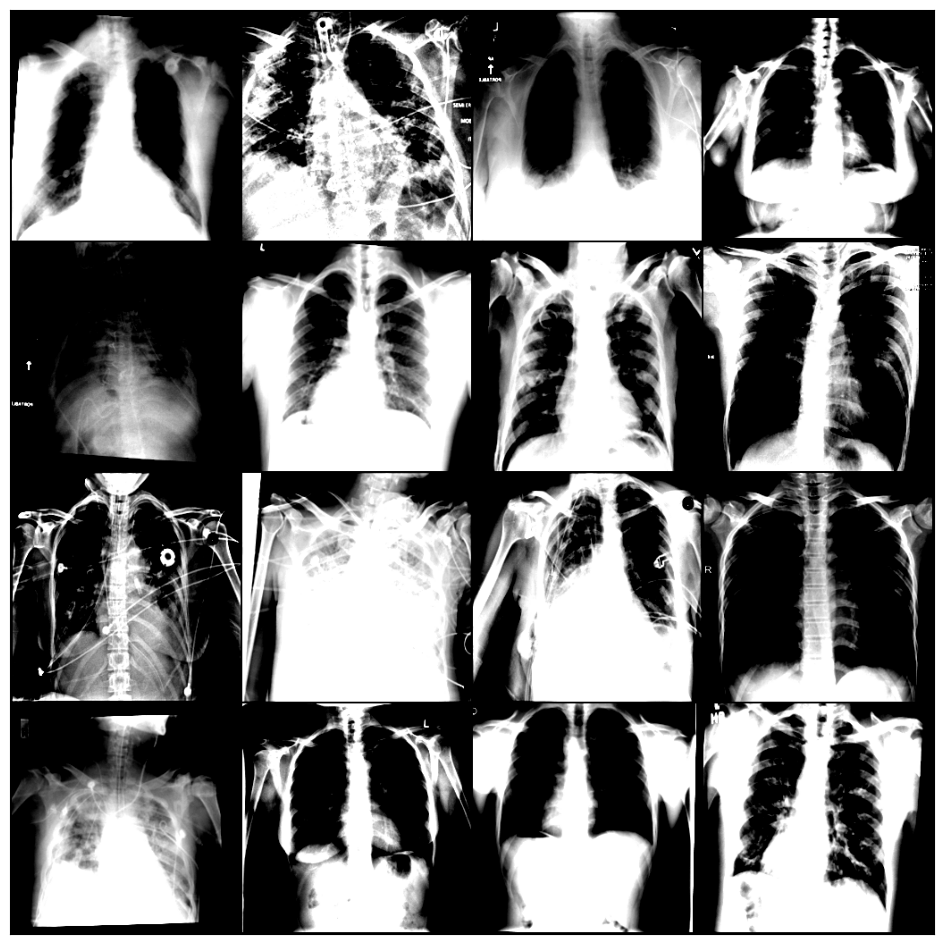

In [19]:
show_batch(train_loader)

## Building the Model

In [20]:
import torch.nn as nn
import torchvision

In [21]:
def medical_resnet34(num_classes=4, input_channels=1):

  # Load base model
  model = torchvision.models.resnet34(pretrained=True)

  # Replace first conv layer for 1-channel input
  model.conv1 = nn.Conv2d(

      input_channels,  # 1 channel input
      64,  # Original number of filters
      kernel_size=7,
      stride=2,
      padding=3,
      bias=False
      )

  # Initialize weights properly for 1-channel input
  if input_channels == 1:
    pretrained_weights = torchvision.models.resnet34(pretrained=True).conv1.weight
    model.conv1.weight.data = pretrained_weights.mean(dim=1, keepdim=True)

  # Modify maxpool to handle 256→128→64 reduction
  model.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

  # Adjust final fully connected layer
  model.fc = nn.Linear(512, num_classes)  # 4 output classes

  return model


In [22]:
model = medical_resnet34(
    num_classes=4,
    input_channels=1,  # For your 1-channel images
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 193MB/s]


In [23]:
# here the architecture of the model
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# checking the input size and output checking for preventing any issue that could happen during model training
for images, labels in train_loader:
    print('images.shape: ', images.shape) #
    out = model(images)
    print('out.shape: ', out.shape)
    break

images.shape:  torch.Size([64, 1, 256, 256])
out.shape:  torch.Size([64, 4])


## Training the Model

In [25]:
from fastai.data.core import DataLoaders
from torch.utils.data import DataLoader
from fastai.learner import Learner
from fastai.metrics import accuracy
import torch.nn.functional as F

In [26]:
# dls = DataLoaders(train_loader, valid_loader)
# If you have Dataset objects instead of DataLoaders
dls = DataLoaders(
    DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
)
# Create Learner (similar to before, but with DataLoaders)
learner = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy)
learner.clip = 0.1  # Gradient clipping (still works the same way)

SuggestedLRs(valley=9.120108734350652e-05)

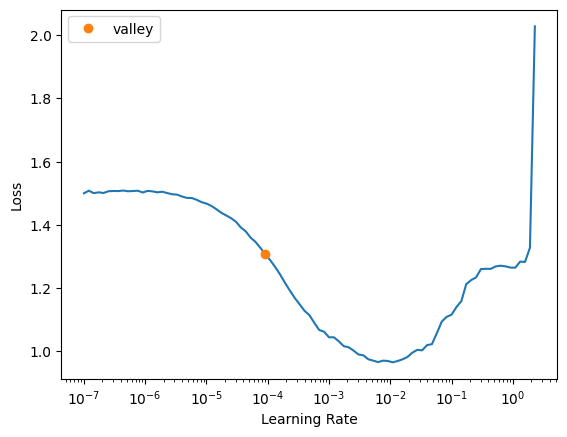

In [27]:
from fastai.vision.all import *
learner.lr_find()

In [28]:
%%time
# measuring the wall time for the model training
learner.fit_one_cycle(15, 5e-2, wd=1e-4 )

[0, 0.6079292297363281, 1.1245744228363037, 0.7193479537963867, '02:37']
[1, 0.5795465111732483, 0.9654759168624878, 0.718875527381897, '02:41']
[2, 0.5312981605529785, 1.069053292274475, 0.6935979127883911, '02:38']
[3, 0.44055864214897156, 1.0270721912384033, 0.6423340439796448, '02:38']
[4, 0.3931540846824646, 0.5768470168113708, 0.8065202236175537, '02:37']
[5, 0.34933650493621826, 0.3487502634525299, 0.8790456056594849, '02:38']
[6, 0.3107013404369354, 0.31624552607536316, 0.8802267909049988, '02:38']
[7, 0.2960474491119385, 0.42626670002937317, 0.8514056205749512, '02:36']
[8, 0.2664310038089752, 0.27481457591056824, 0.9038506746292114, '02:35']
[9, 0.23995409905910492, 0.20799462497234344, 0.9279471039772034, '02:35']
[10, 0.19806064665317535, 0.20219723880290985, 0.9321993589401245, '02:35']
[11, 0.1841128170490265, 0.1921471208333969, 0.9371604323387146, '02:35']
[12, 0.1647595465183258, 0.18723919987678528, 0.9376328587532043, '02:35']
[13, 0.15586654841899872, 0.177509352564

In [31]:
os.makedirs('xray_disease_app/models', exist_ok=True)

In [32]:
# After training completes
torch.save({
    'model_state_dict': model.state_dict(),
    'classes': ['normal', 'viral_pneumonia', 'lung_opacity', 'covid']
}, 'xray_disease_app/models/medical_resnet34.pt')

In [33]:
torch.save({
    'model_state_dict': model.state_dict(),
    'classes': ['normal', 'viral_pneumonia', 'lung_opacity', 'covid']
}, '/content/sample/MyDrive/ResNet/xray_disease_app/models/medical_resnet34.pt')